In [2]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
import os
from tensorflow.keras import backend as K

K.clear_session()

os.chdir('/home/coder/workspace/Data/2DOF_Machine/')
name1 = '2DOF_Balanced_Data2_23-10-06_with_CG.csv'
name2 = '2DOF_Balanced_Data1_23-10-06_with_CG.csv'
name3 = '2DOF_Balanced_Data_23-10-06_with_CG.csv'
name4 = '2DOF_1High_Vert_Data1_23-10-06_with_CG.csv'
name5 = '2DOF_1High_Vert_Data_23-10-06_with_CG.csv'
name6 = '2DOF_1High_Vert_Data_23-10-06_with_CG.csv'

# names = [name1, name2, name3, name4, name5, name6]
names = [name1, name2, name3]
# names = [name1]

# combining data sets end to end
data = np.empty((0,12))
for name in names:
    datum = pd.read_csv(name)
    data = np.concatenate((data, datum), axis=0)

data = pd.DataFrame(data)

print(data.shape)

(220233, 12)


In [87]:
# resetting RAM in gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [88]:
def normalize_data(data):
    """
    Normalize data between 0 and 1 using Min-Max scaling for pandas DataFrame.
    
    Parameters:
    data (pandas DataFrame): Input data to be normalized.
    
    Returns:
    pandas DataFrame: Normalized data.
    """
    min_vals = data.min()
    max_vals = data.max()
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data


def lowpass(order, highStop, sampleRate, data):
    '''
    The function uses a Butterworth low pass filter and returns the filtered time-series data

    :param order: order of the filter (higher order means faster roll off), int
    :param highStop: high frequency before the roll off starts, int
    :param sampleRate: sample rate at which the data was collected, int
    :param data: collected data, array_like
    '''
    b, a = butter(order, highStop, 'lowpass', fs=sampleRate)
    return filtfilt(b, a, data)


Checking filtered data. Balance between smoothness but maintaining feature definition


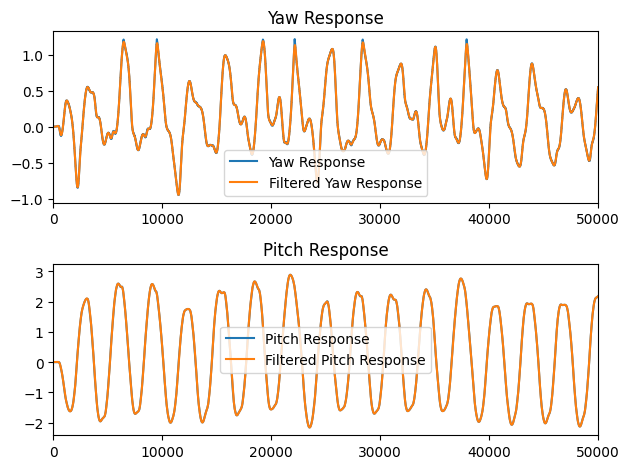

In [89]:
# May try normailizing the data in the future
# data = normalize_data(data)

t = data.iloc[:,0].values
yaw_input = data.iloc[:,1].values
yaw_response = data.iloc[:,2].values
motor_input1 = data.iloc[:,3].values
motor_input2 = data.iloc[:,4].values
pitch_input = data.iloc[:,5].values
pitch_response = data.iloc[:,6].values
motor_response_yaw = data.iloc[:,7].values
motor_response_pitch = data.iloc[:,8].values
pitch_acceleration = data.iloc[:,9].values
yaw_acceleration = data.iloc[:,10].values


# Filter position inputs to reduce measurement noise
order = 3
# This parameter needs to strike a balance between smooth for diffrentiation but not losing features
highStop = 5
sampleRate = len(data)/t[-1]

yaw_response_filt = lowpass(order, highStop, sampleRate, yaw_response)
pitch_response_filt = lowpass(order, highStop, sampleRate, pitch_response)

print('Checking filtered data. Balance between smoothness but maintaining feature definition')

# plotting to check data
plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
plt.plot(yaw_response, label='Yaw Response')
plt.plot(yaw_response_filt, label='Filtered Yaw Response')
plt.xlim([0, 50000])
plt.legend()
plt.title('Yaw Response')

# Plot pitch response and its filtered version
plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
plt.plot(pitch_response, label='Pitch Response')
plt.plot(pitch_response_filt, label='Filtered Pitch Response')
plt.xlim([0, 50000])
plt.legend()
plt.title('Pitch Response')

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

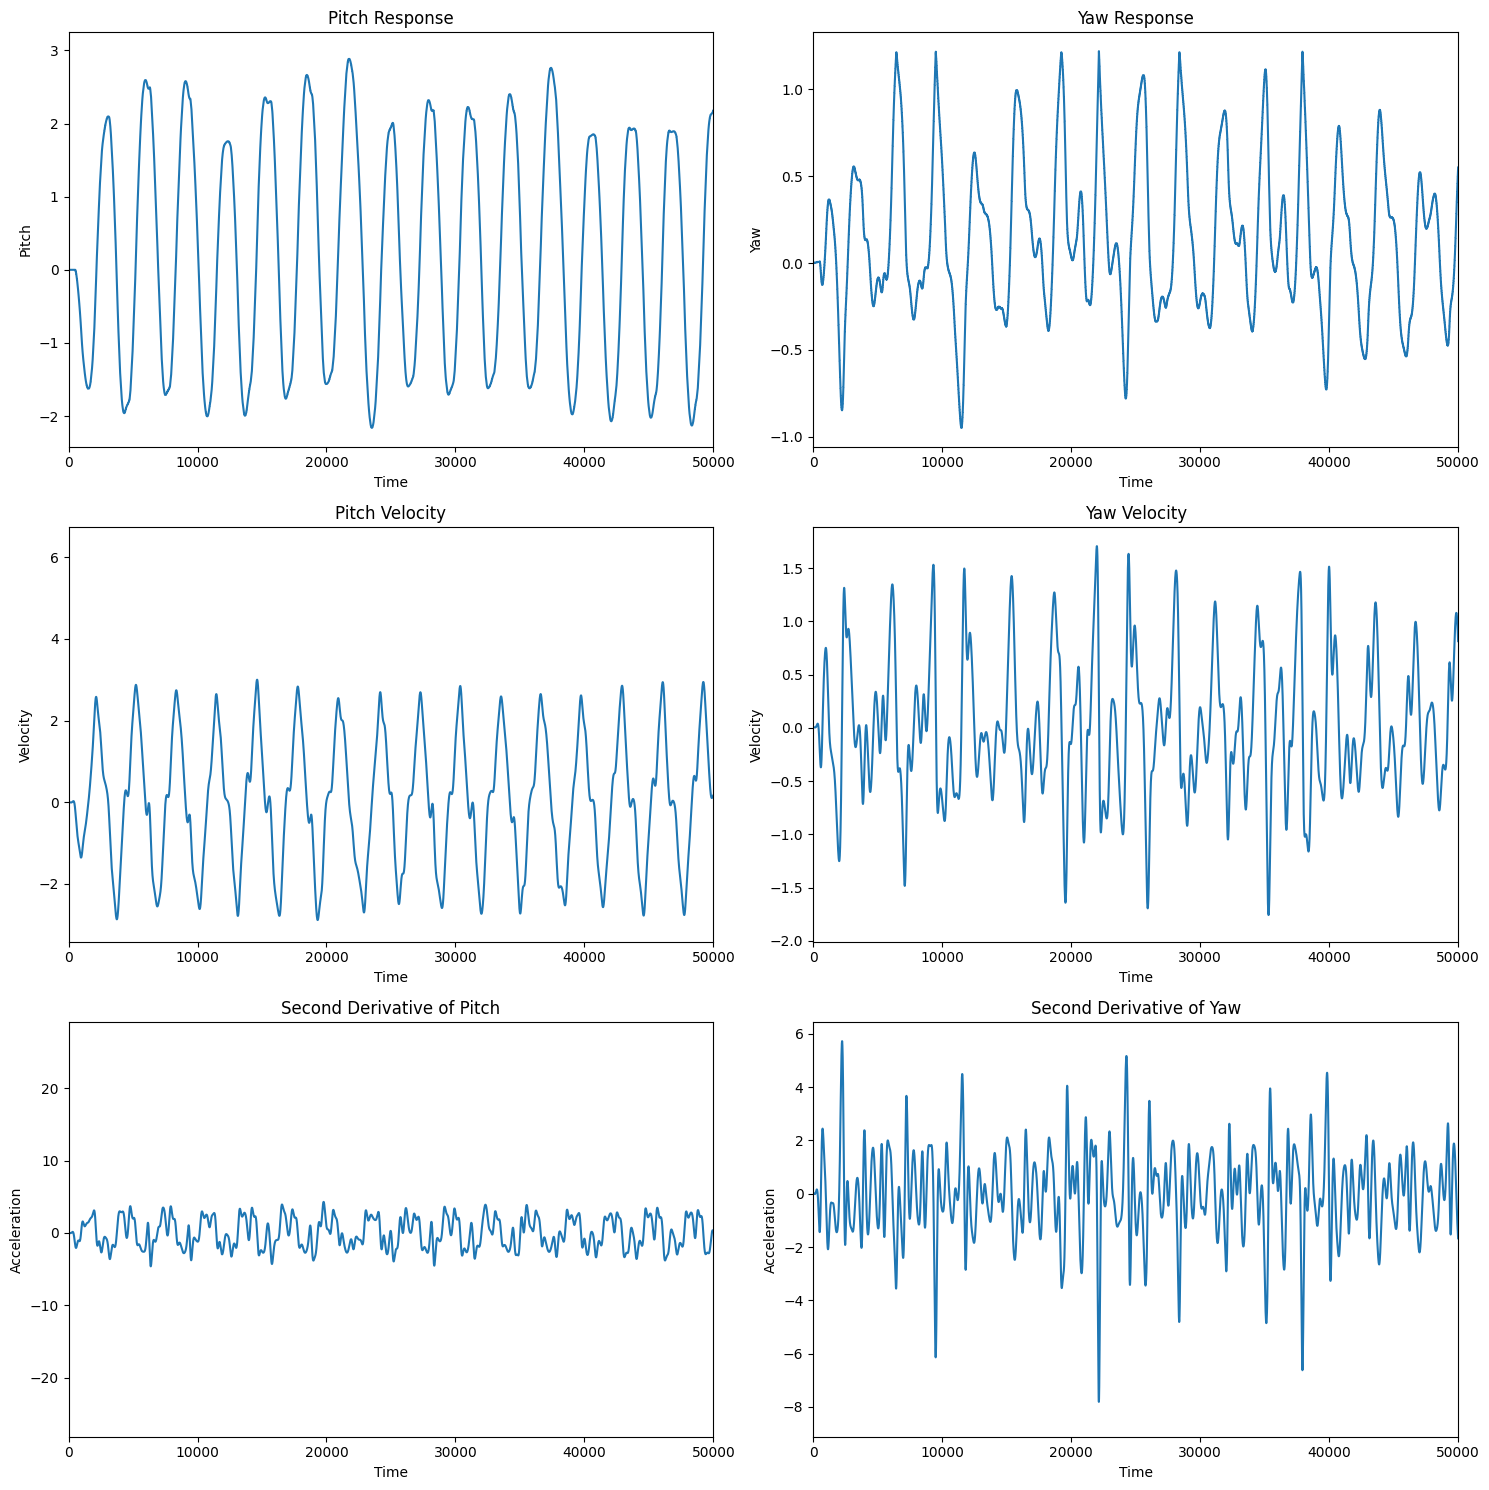

In [90]:
# Compute velocity derivatives
tstep = t[2]-t[1]
pitch_velocity = np.array([np.diff(pitch_response_filt, n=1)])
pitch_velocity = np.transpose(pitch_velocity)/tstep
pitch_velocity= np.append(pitch_velocity, 0)
yaw_velocity = np.array([np.diff(yaw_response_filt, n=1)])
yaw_velocity = np.transpose(yaw_velocity)/tstep
yaw_velocity = np.append(yaw_velocity, 0)

# Compute acceleration derivatives
# We are computing accelerations becuase we don't trust the measured values are labeled correctly
d2pitchdt2 = np.array([np.diff(pitch_velocity, n=1)])
d2pitchdt2 = np.transpose(d2pitchdt2)/tstep
d2pitchdt2= np.append(d2pitchdt2, 0)
d2yawdt2 = np.array([np.diff(yaw_velocity, n=1)])
d2yawdt2 = np.transpose(d2yawdt2)/tstep
d2yawdt2 = np.append(d2yawdt2, 0)

# plotting as a data check
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Adjust figsize as needed

# Set common x-axis limits for all subplots
for row in axs:
    for ax in row:
        ax.set_xlim([0, 50000])
        # ax.set_xlim([0,len(pitch_response)]) 

# Plot pitch response in the first subplot
axs[0, 0].plot(pitch_response)
axs[0, 0].set_title('Pitch Response')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Pitch')

# Plot pitch velocity in the second subplot
axs[1, 0].plot(pitch_velocity)
axs[1, 0].set_title('Pitch Velocity')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Velocity')

# Plot second derivative of pitch in the third subplot
axs[2, 0].plot(d2pitchdt2)
axs[2, 0].set_title('Second Derivative of Pitch')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Acceleration')

# Plot yaw response in the fourth subplot
axs[0, 1].plot(yaw_response)
axs[0, 1].set_title('Yaw Response')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Yaw')

# Plot yaw velocity in the fifth subplot
axs[1, 1].plot(yaw_velocity)
axs[1, 1].set_title('Yaw Velocity')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Velocity')

# Plot second derivative of yaw in the sixth subplot
axs[2, 1].plot(d2yawdt2)
axs[2, 1].set_title('Second Derivative of Yaw')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('Acceleration')

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

In [91]:
inputs = np.array([t, yaw_input, yaw_response, motor_input1, motor_input2,
    pitch_input, pitch_response, motor_response_yaw, motor_response_pitch,
    pitch_acceleration, yaw_acceleration, pitch_velocity, yaw_velocity,
    d2yawdt2]) # Everything in the order previously defined
inputs = np.transpose(inputs)

outputs = np.array([d2pitchdt2])
outputs = np.transpose(outputs)

print("Shape of inputs array:", inputs.shape)
print("Shape of outputs array:", outputs.shape)

input_train, input_test, output_train, output_test = train_test_split(inputs, outputs, shuffle=False, test_size=0.25)

model = Sequential([
    Dense(units=500, activation='tanh'),
    Dense(units=200, activation='tanh'),
    Dense(units=200, activation='tanh'),
    Dense(units=100, activation='tanh'),
    Dense(units=5, activation='linear') # Outputs pitch acceleration and a 4 predicted coefficients
])

optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

Shape of inputs array: (220233, 14)
Shape of outputs array: (220233, 1)


In [92]:
def custom_loss(input_train, output_train, net, itr):
    # Convert inputs and outputs to tensors
    input_train = tf.convert_to_tensor(input_train, dtype=tf.float32)
    output_train = tf.convert_to_tensor(output_train, dtype=tf.float32)

    # Assign an array for the current set of network predictions
    # These are the coefficients that are going to be used in calculating eq. loss
    # and acceleration for collocation loss
    predictions = net(input_train)

   # unpack coefficients
    pred_coeff1 = net(input_train)[:,1]
    pred_coeff2 = net(input_train)[:,2]
    pred_coeff3 = net(input_train)[:,3]
    pred_coeff4 = net(input_train)[:,4]

    # calculate 1st and 2nd numerical derivatives of the coeffiecients
    grad1 = tf.experimental.numpy.diff(pred_coeff1)
    dgrad1 = tf.experimental.numpy.diff(grad1)
    grad2 = tf.experimental.numpy.diff(pred_coeff2)
    dgrad2 = tf.experimental.numpy.diff(grad2)
    grad3 = tf.experimental.numpy.diff(pred_coeff3)
    dgrad3 = tf.experimental.numpy.diff(grad3)
    grad4 = tf.experimental.numpy.diff(pred_coeff4)
    dgrad4 = tf.experimental.numpy.diff(grad4)

    # reshape coeffiecients and their derivatives
    pred_coeff1 = tf.expand_dims(pred_coeff1, axis=1)
    pred_coeff2 = tf.expand_dims(pred_coeff2, axis=1)
    pred_coeff3 = tf.expand_dims(pred_coeff3, axis=1)
    pred_coeff4 = tf.expand_dims(pred_coeff4, axis=1)
    grad1 = tf.expand_dims(grad1, axis=1)
    dgrad1 = tf.expand_dims(dgrad1, axis=1)
    grad2 = tf.expand_dims(grad2, axis=1)
    dgrad2 = tf.expand_dims(dgrad2, axis=1)
    grad3 = tf.expand_dims(grad3, axis=1)
    dgrad3 = tf.expand_dims(dgrad3, axis=1)
    grad4 = tf.expand_dims(grad4, axis=1)
    dgrad4 = tf.expand_dims(dgrad4, axis=1)

    # unpack and reshape the acceleration prediction
    pred_pitch_accel = predictions[:,0]
    pred_pitch_accel = tf.expand_dims(pred_pitch_accel, axis=1)

    # Compute L_c: Collocation point loss
    L_c = tf.reduce_mean(tf.square(output_train - pred_pitch_accel))

    # Getting variables ready for equation loss
    theta = input_train[:,2] # theta = yaw_response
    theta = tf.expand_dims(theta, axis=1)
    dtheta = input_train[:,12] # dtheta = yaw_velocity
    dtheta = tf.expand_dims(dtheta, axis=1)
    Vp = input_train[:,8] # 
    Vp = tf.expand_dims(Vp, axis=1) 
    Vy = input_train[:,7]
    Vy = tf.expand_dims(Vy, axis=1)
    
    # Compute L_eq: Equation Loss
    # This is based on the state space model of the Quanser
    L_eq = tf.reduce_mean(tf.square(pred_coeff1*theta+pred_coeff2*dtheta+pred_coeff3*Vp+pred_coeff4*Vy-output_train)) # Voltage is in Volts

    # Gradient loss: trying to force the coefficients to be constant
    L_gr1 = tf.reduce_mean(tf.square(grad1 - 0)) + tf.reduce_mean(tf.square(dgrad1 - 0))
    L_gr2 = tf.reduce_mean(tf.square(grad2 - 0)) + tf.reduce_mean(tf.square(dgrad2 - 0))
    L_gr3 = tf.reduce_mean(tf.square(grad3 - 0)) + tf.reduce_mean(tf.square(dgrad3 - 0))
    L_gr4 = tf.reduce_mean(tf.square(grad4 - 0)) + tf.reduce_mean(tf.square(dgrad4 - 0))

    L_gr = L_gr1 + L_gr2 + L_gr3 + L_gr4

    # Adjusting loss component weights trying to make them roughly equal
    # Automatically adjust the weights after the first run
    if itr == 0:
        global L_eq_norm, L_gr_norm, L_c_norm
        L_eq_norm = L_eq
        L_gr_norm = L_gr
        L_c_norm = L_c

    L_eq = L_eq/L_eq_norm
    L_gr = L_gr/L_gr_norm
    L_c = L_c/L_c_norm

    L_total = L_eq + L_c + L_gr

    return L_total

In [93]:
def nrmse(actual_values, predicted_values):
    """
    Calculate Normalized Root Mean Squared Error (NRMSE) for regression. Normalized over the range of the target variable
    In this case it's the range of the pitch acceleration data

    Parameters:
    - actual_values: NumPy array or list of actual values.
    - predicted_values: NumPy array or list of predicted values.

    Returns:
    - nrmse: Normalized Root Mean Squared Error.
    """
    actual_values = np.array(actual_values).flatten()
    predicted_values = np.array(predicted_values).flatten()

    if len(actual_values) != len(predicted_values):
        raise ValueError("Length of actual_values and predicted_values must be the same.")

    # Calculate RMSE
    rmse = np.sqrt(np.mean((actual_values - predicted_values) ** 2))

    # Calculate the range of the target variable
    target_range = np.max(actual_values) - np.min(actual_values)

    # Calculate NRMSE
    nrmse = (rmse / target_range) * 100 # Expressed as a percentage

    return nrmse


0 :  3.0
200 :  0.22855265
400 :  0.14292498
600 :  0.10678312
800 :  0.063449495
1000 :  0.07834375
1200 :  0.04423598
1400 :  0.03859896
1600 :  0.034224954
1800 :  0.040902052


Text(0.5, 1.0, 'Training loss per epoch')

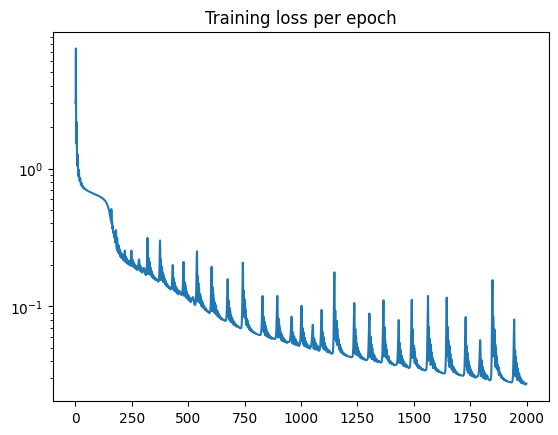

In [94]:
# Training loop

train_loss_record = []
for itr in range(2000):
    with tf.GradientTape() as tape:
        train_loss = custom_loss(input_train, output_train, model, itr)
        train_loss_record.append(train_loss)
        grad_w = tape.gradient(train_loss, model.trainable_variables)
        optm.apply_gradients(zip(grad_w, model.trainable_variables))

    if itr % 200 == 0:
        print(itr, ': ', train_loss.numpy())

plt.semilogy(train_loss_record)
plt.title('Training loss per epoch')


In [95]:
# Making Predictions
pitch_predictions_fnn = model.predict(input_test)

   1/1721 [..............................] - ETA: 1:30

1721/1721 [==============================] - 2s 1ms/step


0.0009218117 -0.321
-0.16949461 -0.086
0.00045531758 0.023
-0.004509431 0.0099


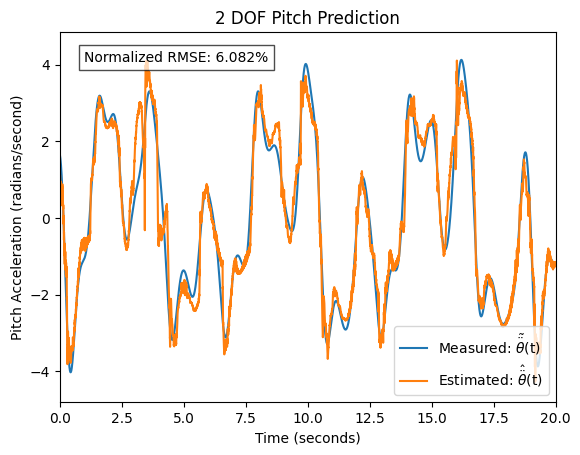

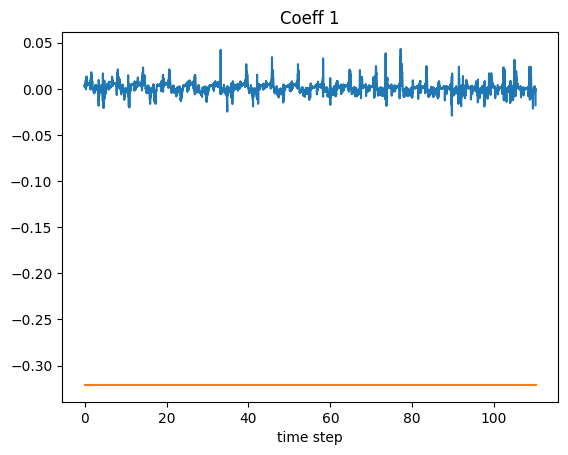

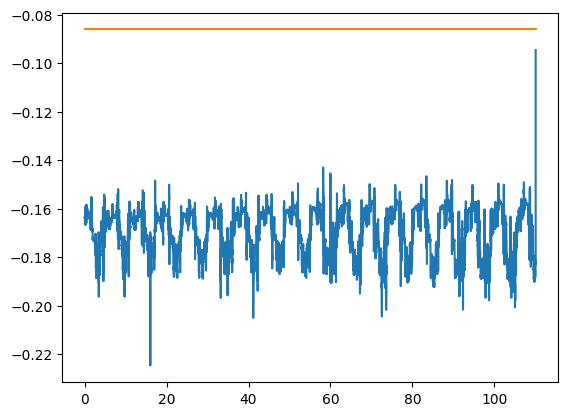

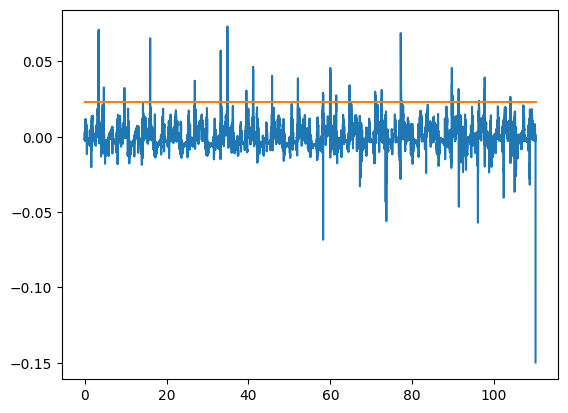

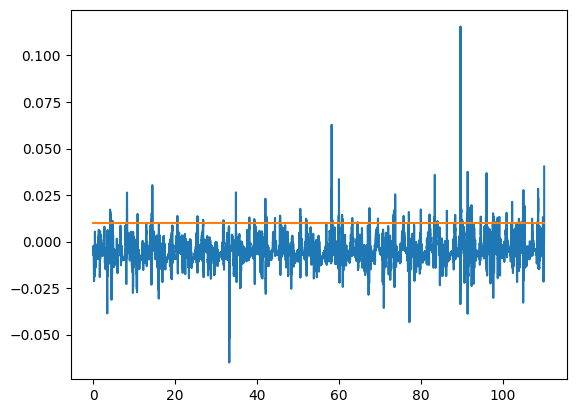

In [102]:
# Plotting

# plt.savefig('collocation_prediction_performance.png', dpi=1000)

# Plotting 
plt.figure()
t = np.linspace(0,len(output_test)/500,len(output_test))
plt.plot(t,output_test)
plt.plot(t,pitch_predictions_fnn[:,0])
plt.legend([r'Measured: $\tilde{\ddot{\theta}}$(t)', r'Estimated: $\hat{\ddot{\theta}}$(t)'])
plt.ylabel('Pitch Acceleration (radians/second)')
plt.xlabel('Time (seconds)')
plt.title('2 DOF Pitch Prediction')
plt.xlim([0,20])

nrmse_value = nrmse(output_test,pitch_predictions_fnn[:,0])
rounded_nrmse = round(nrmse_value, 3)
nrmse_text = f'Normalized RMSE: {rounded_nrmse}%'
# Add a textbox with the NRMSE value
plt.annotate(nrmse_text, xy=(0.05, 0.92), xycoords='axes fraction', bbox=dict(facecolor='white', alpha=0.7))


plt.figure()
predict_coeff1 = pitch_predictions_fnn[:,1]
plt.plot(t,predict_coeff1)
plt.plot([0,t[-1]], [-0.321,-0.321])
plt.xlabel('time step')
plt.title('Coeff 1')
print(np.mean(predict_coeff1), -0.321)

plt.figure()
predict_coeff2 = pitch_predictions_fnn[:,2]
plt.plot(t,predict_coeff2)
plt.plot([0,t[-1]], [-0.086, -0.086])
print(np.mean(predict_coeff2), -0.086)

plt.figure()
predict_coeff3 = pitch_predictions_fnn[:,3]
plt.plot(t,predict_coeff3)
plt.plot([0,t[-1]], [0.023, 0.023])
print(np.mean(predict_coeff3), 0.023)

plt.figure()
predict_coeff4 = pitch_predictions_fnn[:,4]
plt.plot(t,predict_coeff4)
plt.plot([0,t[-1]], [0.0099, 0.0099])
print(np.mean(predict_coeff4), 0.0099)